In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm

starry.config.quiet = True
np.random.seed(1)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
starry.config.lazy = False
starry.config.quiet = True

In [3]:
t = np.linspace(0, 1, 500)

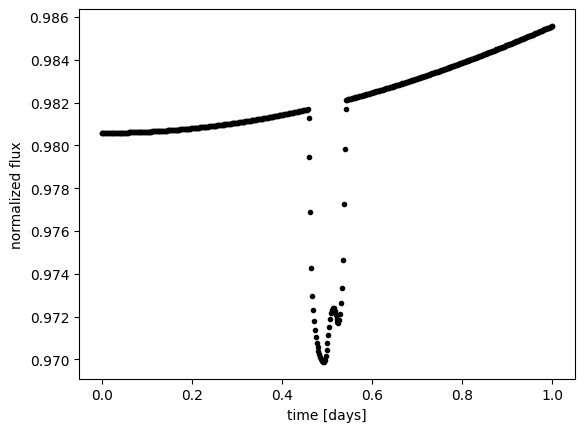

In [55]:
map = starry.Map(ydeg=15, udeg=2)
contrast = 0.25
radius = 15
map.spot(contrast=contrast, radius=radius)

rp_true = 0.1
porb = 1. 
t0 = 0.5
mp = 6e-4
ecc=0.0
u1 = 0.40
u2 = 0.26

star = starry.Primary(map, m=1.0, r=1.0, prot=10.0)
star.map[1] = u1
star.map[2] = u2

planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=mp,  # mass in solar masses
    r=rp_true,  # radius in solar radii
    porb=porb,  # orbital period in days
    ecc=ecc,  # eccentricity
    t0=t0,  # time of transit in days
)
system = starry.System(star, planet)

flux_star, flux_planet = system.flux(t, total=False)

plt.plot(t, flux_star, 'k.')
plt.xlabel("time [days]")
plt.ylabel("normalized flux");
plt.show()

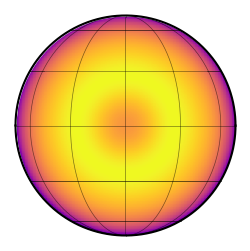

In [5]:
map.show()

In [6]:
xo, yo, zo = system.position(t)
xo = xo[1]
yo = yo[1]
zo = zo[1]

In [7]:
theta = (360 * t / 10.0) % 360

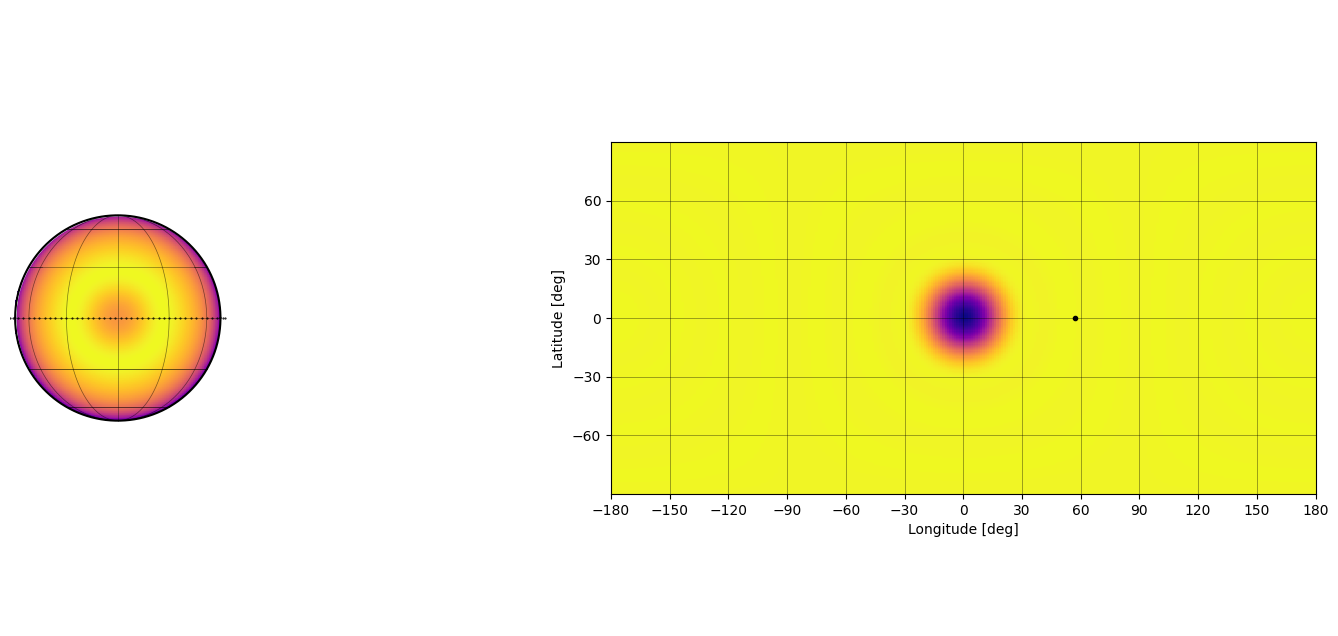

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
ax[0].set_aspect(1)
ax[0].axis("off")
# map[:, :] = y
map.show(ax=ax[0])
ax[0].set_ylim(-3, 3)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat = 180 / np.pi * np.arcsin(yo[idx])
lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon = (lon + 180) % 360 - 180
mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
map.show(ax=ax[1], projection="rect")
ax[1].plot(lon, lat + mask, "k.");

In [9]:
ferr = 1e-4
err = np.ones_like(flux_star) * ferr
noise = np.random.randn(len(t)) * err
flux_true = flux_star + noise

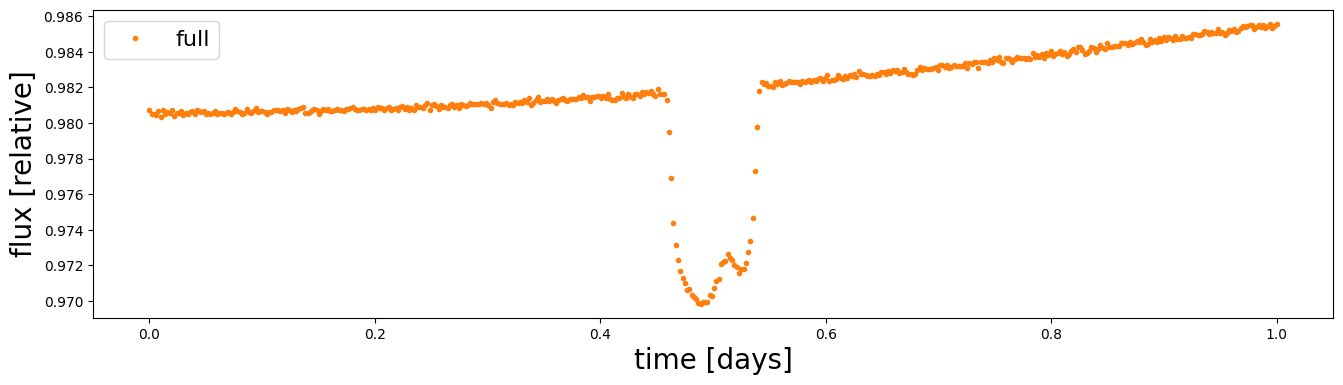

In [10]:
# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux_true, "C1.", alpha=1, label="full")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [11]:
y = map.y

In [12]:
lat, lon, Y2P, P2Y, Dx, Dy = map.get_pixel_transforms(oversample=4)

In [13]:
p = Y2P.dot(y)

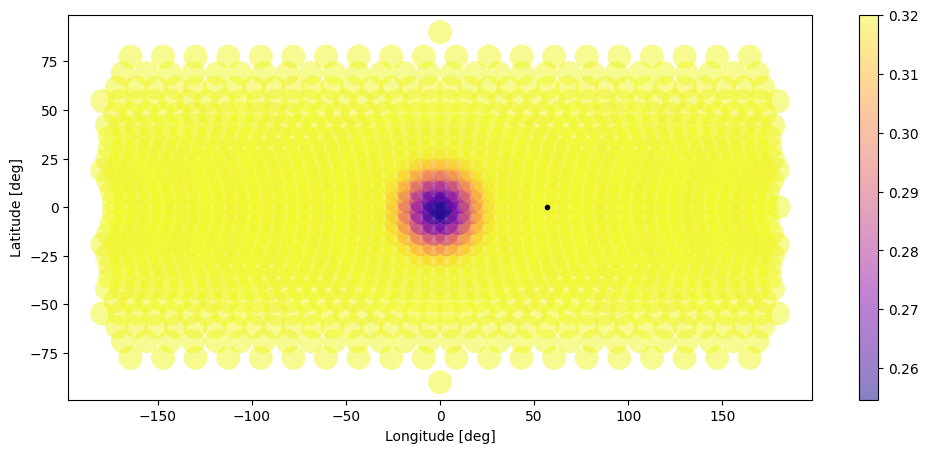

In [14]:
fig, ax = plt.subplots(1, figsize=(12, 5))
im = ax.scatter(lon, lat, s=300, c=p, ec="none", cmap="plasma", alpha=0.5)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)

lat_p = 180 / np.pi * np.arcsin(yo[idx])
lon_p = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon_p = (lon_p + 180) % 360 - 180

mask = np.append(np.array(lon_p[1:] > lon_p[:-1], dtype=float), 0)
mask[mask == 1] = np.nan

# im = ax.scatter(lon, lat, s=300, c=p, alpha=0.5, ec="none", cmap="plasma")
ax.plot(lon_p, lat_p + mask, "k.");

plt.colorbar(im)
# ax.set_xlim(-190, 190)
# ax.set_ylim(-90, 90)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]");

In [57]:
A = map.design_matrix(
    theta=theta, xo=xo, yo=yo, zo=zo, ro=rp_true
)

# *** Draw 1 sample from the GP
sp = StarryProcess(
    r=15,
    c=0.25,
    n=1,
    mu=0,
    sigma=30,
    marginalize_over_inclination=False,  
    normalized=False,
)

Sigma_s = sp.cov_ylm 
mu_ylm = sp.mean_ylm
# mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
mu_flux = tt.dot(A, mu_ylm) #/ norm
K = len(t)

U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))

log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
# log_sigmadet -= 2*256*tt.log(norm)

r = tt.as_tensor_variable(flux_true) - mu_flux
v = tt.dot(A.T,(r/tt.square(err)))
Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))

loglike = -0.5 * Q
loglike -= 0.5  * log_sigmadet
loglike -= 0.5 * K * tt.log(2 * np.pi)

In [17]:
loglike.eval()

array(-103.29568973)

In [18]:
y = sp.sample_ylm_conditional(t=t, flux=flux_true, data_cov=err**2, nsamples=1, A=A, p=10.0).eval().reshape(-1)

In [19]:
map_samp = starry.Map(ydeg=15, udeg=2)
map_samp[:,:] = y

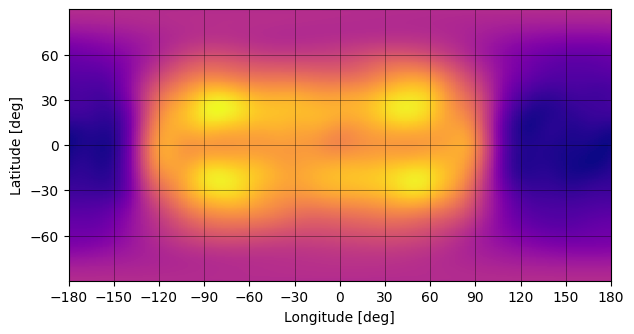

In [20]:
map_samp.show(projection="rect")

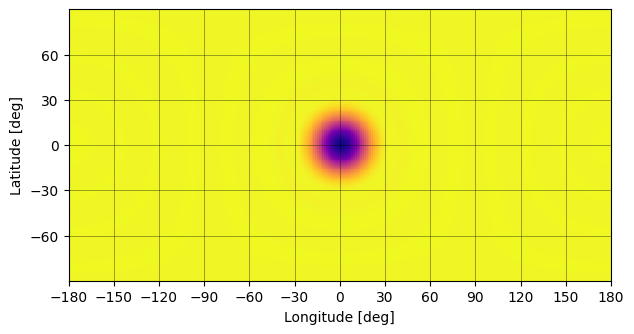

In [21]:
map.show(projection="rect")

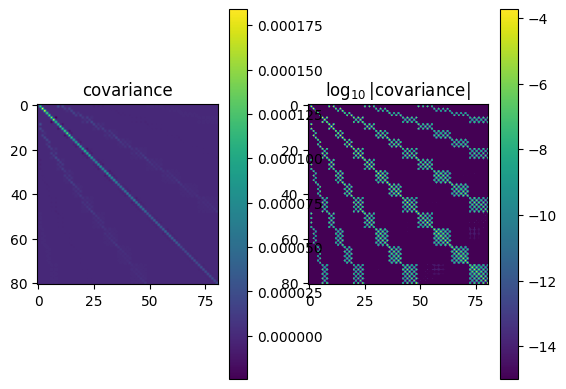

In [22]:
fig, ax = plt.subplots(1, 2)
im = ax[0].imshow(Sigma_s.eval()[:81, :81])
plt.colorbar(im, ax=ax[0])
ax[0].set_title("covariance")
im = ax[1].imshow(np.log10(np.abs(Sigma_s.eval()[:81, :81])), vmin=-15)
plt.colorbar(im, ax=ax[1])
ax[1].set_title("$\log_{10}|\mathrm{covariance}|$")
plt.show()

In [23]:
lat = np.linspace(-90, 90, 100)
lon = np.linspace(-180, 180, 100)
latlon = np.transpose(np.meshgrid(lat, lon))

In [24]:
cov_pix = sp.cov_pix(latlon).eval()

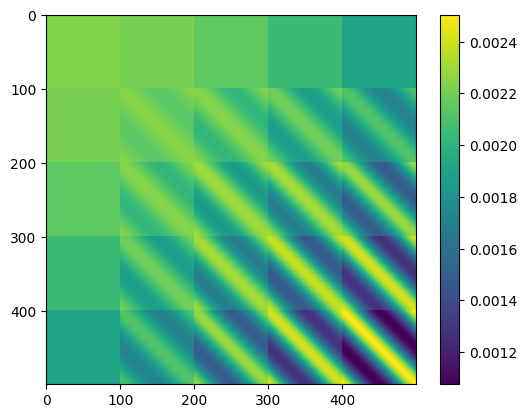

In [25]:
plt.imshow(cov_pix[:500, :500])
plt.colorbar()
plt.show()

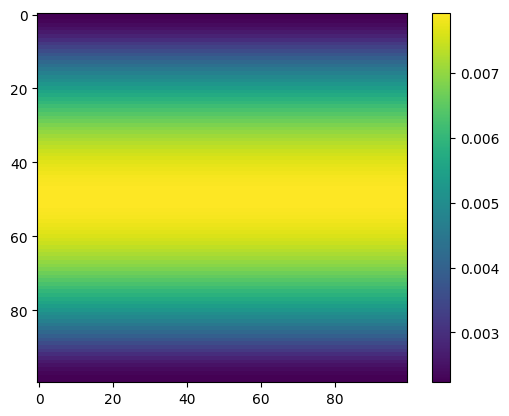

In [26]:
plt.imshow(np.diag(cov_pix).reshape(100, 100))
plt.colorbar()
plt.show()

In [27]:
cov_pix.shape

(10000, 10000)

In [41]:
lat, lon, Y2P, P2Y, Dx, Dy = map.get_pixel_transforms(oversample=4)

In [42]:
cov_pix = sp.cov_pix(latlon=np.concatenate((lon, lat)).reshape(len(lon),2, order='F')).eval()

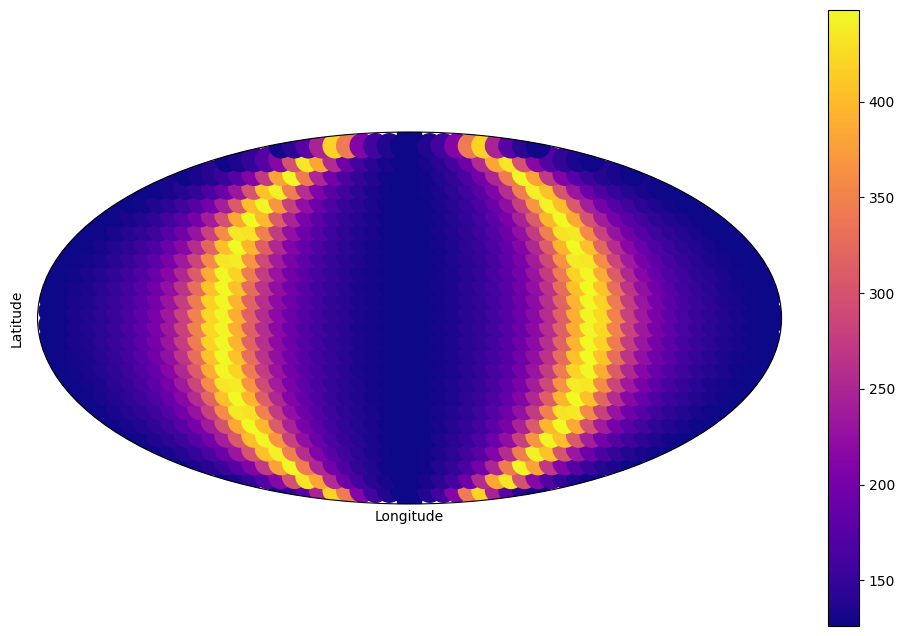

In [43]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='mollweide')
cax = ax.scatter(np.deg2rad(lon), np.deg2rad(lat), c=np.diag(1/cov_pix), s=300, cmap='plasma')
# ax.grid(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
plt.show()

In [44]:
cov_pix = Y2P @ Sigma_s.eval() @ Y2P.T

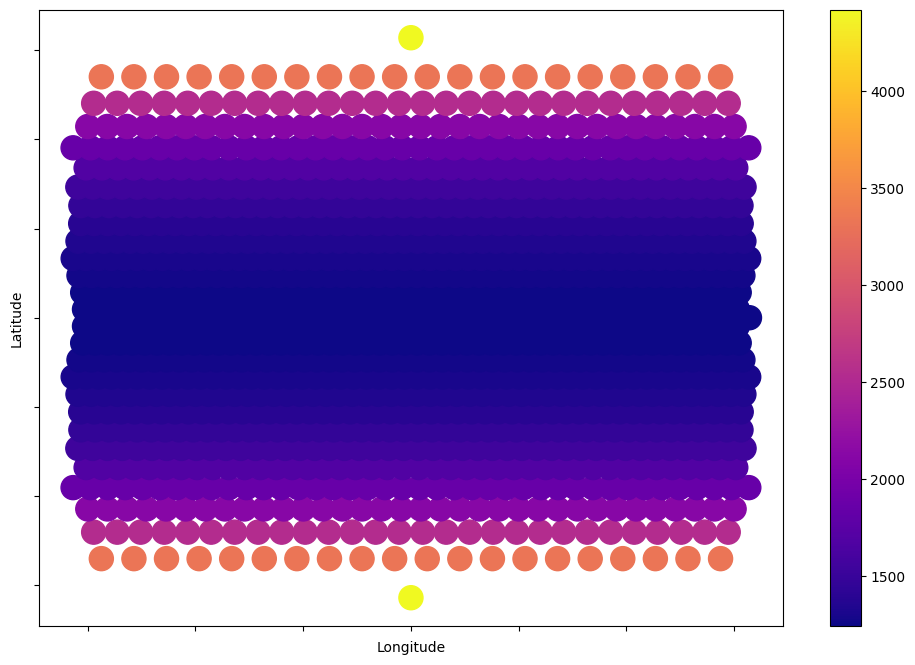

In [45]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
cax = ax.scatter(np.deg2rad(lon), np.deg2rad(lat), c=np.diag(1/cov_pix), s=300, cmap='plasma')
# ax.grid(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
plt.show()

In [28]:
lat.shape

(1156,)

In [38]:
with pm.Model() as model:

    starry.config.lazy = True

    map_model = starry.Map(ydeg=15, udeg=2)
    
    rp = pm.Uniform('rp',lower=0.099, upper=0.11)
    porb = pm.Uniform('porb',lower=0.999999, upper=1.00000001)
    t0 = pm.Uniform("t0",lower=0.499999, upper=0.50000001)
    mp = pm.Uniform('mp',lower=5.9e-4, upper=6.1e-4)
    ecc=0.0
    u1 = pm.Uniform('u1',lower=0.3, upper=0.5)
    u2 = pm.Uniform('u2',lower=0.25, upper=0.27)
    prot = pm.Uniform('prot',lower=9, upper=11)

    A = starry.Primary(map_model, m=1.0, r=1.0, prot=prot)
    A.map[1] = u1
    A.map[2] = u2

    b = starry.kepler.Secondary(
        starry.Map(ydeg=5, amp=5e-3),  # the surface map
        m=mp,  # mass in solar masses
        r=rp,  # radius in solar radii
        porb=porb,  # orbital period in days
        ecc=ecc,  # eccentricity
        t0=t0,  # time of transit in days
    )
    sys = starry.System(A, b)

    flux_model, flux_p = sys.flux(t, total=False)

    pm.Deterministic("lc_model", flux_model)
    # lc_model_guess = pmx.eval_in_model(lc_model)


    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=err, observed=flux_star)

In [39]:
with model:
    soln = pmx.optimize(options=dict(maxiter=9999))
    flux_model = soln["lc_model"]

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fc2c8aa73d0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fc2c8aa73d0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fc2c8aa73d0>.1

message: Desired error not necessarily achieved due to precision loss.
logp: -7788332.528568156 -> -7700248.001768419


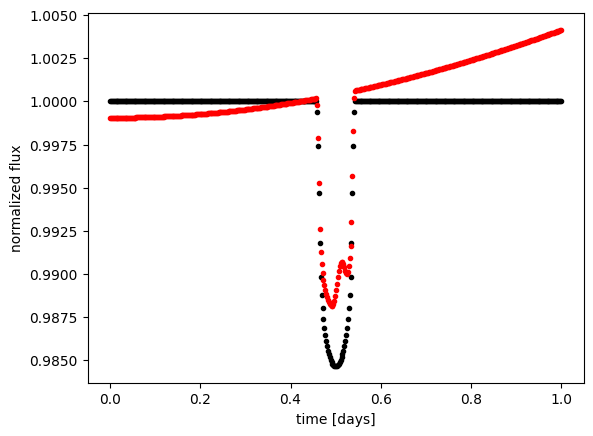

In [42]:
plt.plot(t, flux_model, 'k.')
plt.plot(t, flux_star/np.mean(flux_star), 'r.')
plt.xlabel("time [days]")
plt.ylabel("normalized flux");
plt.show()

In [46]:
lat, lon, Y2P, P2Y, Dx, Dy = map.get_pixel_transforms(oversample=2)

In [47]:
ny = len(map.y)
npix = lat.shape[0]

In [64]:
with pm.Model() as model:
    starry.config.lazy = True

    # *** Draw 1 sample from the GP
    sp = StarryProcess(
        r=15,
        c=0.25,
        n=1,
        marginalize_over_inclination=False,  
        normalized=False,
    )

    y = sp.sample_ylm_conditional(t=t, flux=flux_true, data_cov=err**2, nsamples=1, A=A, p=prot)

    pm.Deterministic("y", y)

    # Compute the flux
    map_model = starry.Map(ydeg=15, udeg=2)
    map_model[:,:] = y.eval().reshape(-1)
    
    rp = pm.Uniform('rp',lower=0.099, upper=0.11)
    porb = pm.Uniform('porb',lower=0.999999, upper=1.00000001)
    t0 = pm.Uniform("t0",lower=0.499999, upper=0.50000001)
    mp = pm.Uniform('mp',lower=5.9e-4, upper=6.1e-4)
    ecc=0.0
    u1 = pm.Uniform('u1',lower=0.3, upper=0.5)
    u2 = pm.Uniform('u2',lower=0.25, upper=0.27)
    prot = pm.Uniform('prot',lower=9, upper=11)

    a = starry.Primary(map_model, m=1.0, r=1.0, prot=prot)
    a.map[1] = u1
    a.map[2] = u2

    b = starry.kepler.Secondary(
        starry.Map(ydeg=5, amp=5e-3),  # the surface map
        m=mp,  # mass in solar masses
        r=rp,  # radius in solar radii
        porb=porb,  # orbital period in days
        ecc=ecc,  # eccentricity
        t0=t0,  # time of transit in days
    )
    sys = starry.System(a, b)

    flux_model, flux_p = sys.flux(t, total=False)

    pm.Deterministic("lc_model", flux_model)


    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=ferr, observed=flux_star)


    Sigma_s = sp.cov_ylm 
    pm.Deterministic("cov", Sigma_s)

In [65]:
with model:
    soln = pmx.optimize(options=dict(maxiter=9999))
    y = np.array(soln["y"])
    cov = soln["cov"]
    flux_model = soln["lc_model"]

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fdfc5efc130>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fdfc5efc130>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x7fdfc5efc130>.1

message: Desired error not necessarily achieved due to precision loss.
logp: -2974.7462756071277 -> -326.3341969530295


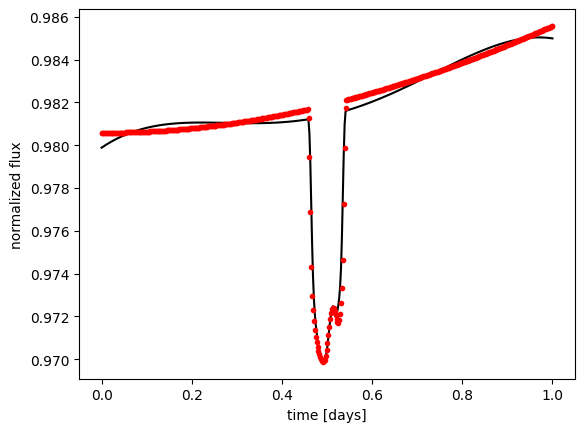

In [72]:
plt.plot(t, flux_model, 'k')
plt.plot(t, flux_star, 'r.')
plt.xlabel("time [days]")
plt.ylabel("normalized flux");
plt.show()


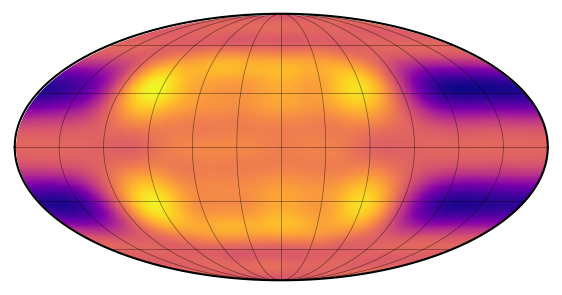

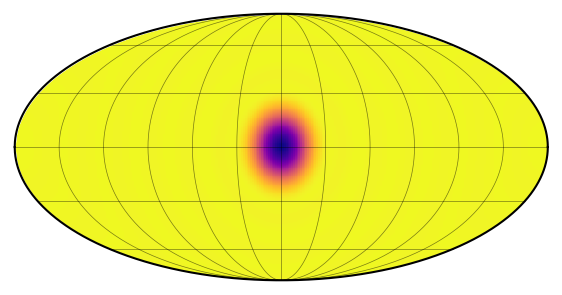

In [70]:
map_inf = starry.Map(ydeg=15, udeg=2)
map_inf[:,:] = y.reshape(-1)
map_inf.show(projection="moll")
map.show(projection="moll")


Text(0, 0.5, 'flux')

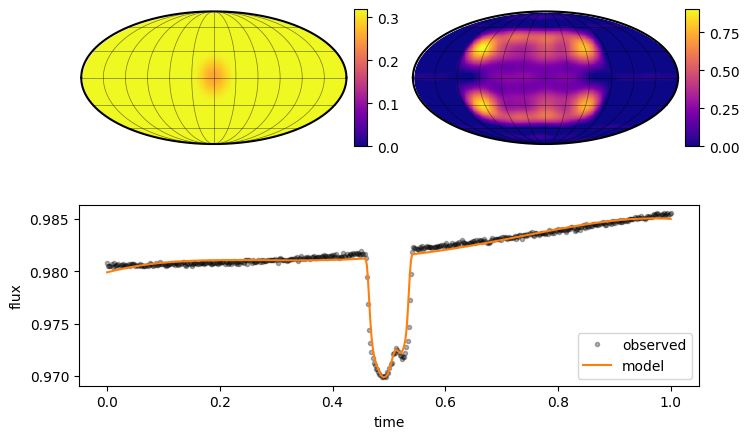

In [73]:
from matplotlib import colors
cmap = plt.get_cmap("plasma")
cmap.set_under("#666666")
cmap.set_over("w")
cnorm = lambda: colors.Normalize(vmin=0.0)
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.15)
ax = [
    plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (1, 0), colspan=2, rowspan=1),
]

# Show the true map
map.show(
    ax=ax[0],
    projection="moll",
    colorbar=True,
    norm=cnorm()
)

# Show the inferred map
map_inf.show(
    ax=ax[1],
    projection="moll",
    colorbar=True,
    norm=cnorm()
)

# Show the flux model
ax[2].plot(t, flux_true, "k.", alpha=0.3, label="observed")
ax[2].plot(t, flux_model, "C1", label="model")
ax[2].legend(fontsize=10, loc="lower right")
ax[2].set_xlabel("time")
ax[2].set_ylabel("flux")